# Bot for data collection in Lattes

## Necessary libraries

In [1]:
try:
    import re
    import threading
    import pandas as pd
    import time as time
    import database as db
    from bs4 import BeautifulSoup
    from unidecode import unidecode
    from selenium import webdriver
    from selenium.webdriver.common.by import By
    from selenium.webdriver.common.keys import Keys 
    from selenium.webdriver.chrome.options import Options
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
except Exception as e:
    print(e)

## Bot

In [2]:
class BotLattes:
    """
    
    Bot para coleta de dados no Lattes
    Limitações:
        - Formação de busca: Doutorado, Mestrado, Todos.
        - Tipos de trabalhos coletados: Artigos completos publicados em periódicos.
        - Participantes do artigo: Apenas o responsável pelo currículo.
    
    """
    def __init__(self, formacao, inicio=0, limitePaginas=None, curriculo=1, nome="Bot", debug=False, **kwargs):
        """
        
        Args:
            formacao [string] : Nível de formação para coleta dos dados.
            inicio [int, optional] : Página a qual será iniciada a coleta de currículos. Defaults to 0.
            limitePaginas [int, optional] : Quantidade máxima de páginas a serem coletadas. Defaults to None.
            curriculo [int, optional] : Currículo inicial da página onde o bot inicia a coleta. Defaults to 1.
            nome [string, optional] : Nome do bot para identificação. Defaults to Bot.
        
        """
        
        print(f"----- Start Bot {nome} - {inicio} <-> {limitePaginas} -----")
        
        try:
            self.anos = kwargs['anos']
        except:
            self.anos = [2018, 2019, 2020, 2021]
            
        try:
            if bool(re.match(kwargs['expressao'].upper(), r'\(([0-9]*( OR )*)*\)')):
                raise TypeError("Invalid phone format")
            
            self.expressao = kwargs['expressao'].upper()
        except:
            self.expressao = '(2018 OR 2019 OR 2020 OR 2021)'
        
        
        #Váriaveis de controle
        self.nome = nome
        self.limite = None
        self.inicio = inicio
        self.inicioP = inicio
        self.fim = limitePaginas
        self.formacao = formacao
        self.debug = debug
        self.pagina = inicio

        #Váriaveis de execução
        self.data = db.DataBase(self.anos)
        self.init = time.perf_counter()
        self.op = Options()
        self.op.headless = True
        self.delay_max = 200
        self.delimiters = ".", ",", ";", ":"
        self.regexPattern = '|'.join(map(re.escape, self.delimiters))
        
            
        
        if self.debug:
            print(f"[Bot {self.nome}]Inicio")
        self.getData(curriculo=curriculo)
        
        print(f"----- End {self.nome} - {self.inicioP} <-> {self.fim} || Tempo de execução: {time.perf_counter()-self.init:.2f} ----\n")
        
    def close(self):
        """
        
        Finaliza o bot e armazena os dados coletados.
        Em caso de erro, finaliza o bot e imprime a mensagem:
        Bot {nome do bot} - Error:\n{erro ocorrido}

        """
        if self.debug:
            print(f"[Bot {self.nome}]Close")
            
        try:
            for ano in self.anos:
                self.data.saveInFile(ano)
            self.data.connectionfile.commit()
            self.data.connection.close()
        except Exception as e:
            print(f"[Bot {self.nome}]Close - Error {e}")
            return
        
    def getData(self, curriculo=1, **kwargs):
        """
        
        Controle da coleta de dados.

        Args:
            curriculo [int, optional] : Currículo inicial da página onde o bot inicia a coleta. Defaults to 1.
        
        """
        
        if self.debug:
            print(f"[Bot {self.nome}]getData")
        
        try:
            self.navegador = webdriver.Chrome(executable_path="./chromedriver",options=self.op)
            
            self.navegador.get("http://buscatextual.cnpq.br/buscatextual/busca.do")
        except Exception as e:
            if self.debug:
                print(f"[Bot {self.nome}]getData - Erro {e}")
            self.getData(curriculo=curriculo)
        
        try:
            self.inicio = kwargs["inicio"]
        except:
            pass
        
        self.parametros()
        
        time.sleep(1)
        
        self.passadas = []

        self.janelaAtual = self.navegador.current_window_handle
        self.passadas.append(self.navegador.window_handles)

        #Variaveis de controle da paginação
        self.pag = 2
        self.troca = True

        self.limite_busca()
        
        self.inicio_coleta()
        
        while True:
            if self.troca:
                self.trocar_pagina()
            self.troca = False
            end = self.selecionar_curriculo(curriculo)
            
            if end[0] == True:
                break
            
            self.data.connection.commit()

            #Limitador de pagínas
            if self.pagina == self.fim:
                break
            
            self.pagina += 1
            curriculo = 1
            self.trocar_pagina()

        self.navegador.quit()
        if self.pagina == self.fim or self.pagina == self.limite:
            self.close()
        else:
            self.getData(curriculo=end[1], **{"inicio": self.pagina})
        
    def parametros(self):
        """
        
        Define os parâmetros de pesquisa.
        
        """
        if self.debug:
            print(f"[Bot {self.nome}]Parametros")
        try:            
            WebDriverWait(self.navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, '//*[@id="tit_simples"]/a')))
            self.navegador.find_element_by_xpath('//*[@id="tit_simples"]/a').click()

            #Tags de pesquisa
            if self.formacao != "doutorado":
                WebDriverWait(self.navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, '//*[@id="buscarDemaisAvancada"]')))
                self.navegador.find_element_by_xpath('//*[@id="buscarDemaisAvancada"]').send_keys(Keys.SPACE) #Buscar demais pesquisadores
                self.navegador.find_element_by_xpath('//*[@id="buscarDoutoresAvancada"]').send_keys(Keys.SPACE) #Buscar demais pesquisadores
                
                if self.formacao == "mestrado":
                    WebDriverWait(self.navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, '//*[@id="filtro2"]')))
                    self.navegador.find_element_by_xpath('//*[@id="filtro2"]').click()
                    time.sleep(1)
                    self.navegador.find_element_by_xpath('//*[@id="nivelFormacao"]').click()
                    self.navegador.find_element_by_xpath('//*[@id="nivelFormacao"]').send_keys(Keys.DOWN)
                    self.navegador.find_element_by_xpath('//*[@id="nivelFormacao"]').send_keys(Keys.DOWN)
                    self.navegador.find_element_by_xpath('//*[@id="nivelFormacao"]').send_keys(Keys.DOWN)
                    self.navegador.find_element_by_xpath('//*[@id="nivelFormacao"]').send_keys(Keys.ENTER)
                    time.sleep(1)
                    #WebDriverWait(navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, '//*[@id="preencheCategoriaNivelBolsa"]')))
                    self.navegador.find_element_by_xpath('/html/body/form/div/div[4]/div/div/div/div[11]/div[2]/div/div/div/a[1]').click()

            WebDriverWait(self.navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, '//*[@id="buscarEstrangeirosAvancada"]')))
            self.navegador.find_element_by_xpath('//*[@id="buscarEstrangeirosAvancada"]').click()

            #Caixa de texto
            buscar = self.navegador.find_element_by_xpath('//*[@id="busca_avancada"]/div/div[2]/div/fieldset/textarea')
            buscar.send_keys("(2021 OR 2022)")
            buscar.send_keys(Keys.ENTER)
        except Exception as e:
            if self.debug:
                print(f"[Bot {self.nome}]Parametros - Erro {e}",end="")
            self.parametros()
            
    def limite_busca(self):
        """
        
        Verifica os limites de coleta.
        
        """
        if self.debug:
            print(f"[Bot {self.nome}]Limite_busca")
        try:
            WebDriverWait(self.navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, '/html/body/form/div/div[4]/div/div/div/div[3]/div/div[1]/b[1]')))
            self.limite = int(self.navegador.find_element_by_xpath('/html/body/form/div/div[4]/div/div/div/div[3]/div/div[1]/b[1]').get_attribute("innerHTML").splitlines()[0])
            self.limite = int(self.limite/10 if self.limite%10==0 else (self.limite/10)+1)
        except Exception as e:
            if self.debug:
                print(f"[Bot {self.nome}]Limite_busca - Erro {e}")
            if self.limite == None:
                self.limite_busca()
            else:
                pass
    
    def inicio_coleta(self):
        """
        
        Seleciona a página de início da coleta.
        
        """
        if self.debug:
            print(f"[Bot {self.nome}]Inicio_coleta")
        if self.inicio!=0:
            try:
                WebDriverWait(self.navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, f'/html/body/form/div/div[4]/div/div/div/div[3]/div/div[4]/a[{self.pag}]')))
                self.navegador.find_element_by_xpath(f'/html/body/form/div/div[4]/div/div/div/div[3]/div/div[4]/a[{self.pag}]').click()
                pagina = self.inicio
                link = self.navegador.current_url.split(";")
                link[0] = link[0].replace(str(10), str((pagina-1)*10))
                link = link[0]+";"+link[1]

                if self.inicio<11:
                    self.pag = self.inicio+1
                elif self.inicio%10==0:
                    self.pag = 13
                else:
                    div = "1"+("0"*(len(str(self.inicio))-1))
                    self.pag = int((self.inicio+1)/int(div))+2
                self.navegador.get(link)
                self.troca = False
                self.inicio = 0
            except Exception as e:
                if self.debug:
                    print(f"[Bot {self.nome}]Inicio_coleta - Erro {e}")
                self.inicio_coleta()
    
    def trocar_pagina(self):
        """
        
        Faz a troca de páginas.
        
        """
        if self.debug:
            print(f"[Bot {self.nome}]Troca_pagina")
        try:
            if self.pagina!=1 and self.pag<=11 and self.pagina<=11:
                WebDriverWait(self.navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, f'/html/body/form/div/div[4]/div/div/div/div[3]/div/div[4]/a[{self.pag}]')))
                self.navegador.find_element_by_xpath(f'/html/body/form/div/div[4]/div/div/div/div[3]/div/div[4]/a[{self.pag}]').click()
                self.pag = self.pag+1 if self.pag<11 else 3

            if self.pagina>11 and self.pag>2:
                WebDriverWait(self.navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, f'/html/body/form/div/div[4]/div/div/div/div[3]/div/div[4]/a[{self.pag}]')))
                self.navegador.find_element_by_xpath(f'/html/body/form/div/div[4]/div/div/div/div[3]/div/div[4]/a[{self.pag}]').click()
                self.pag = self.pag+1 if self.pag<13 else 3
        except Exception as e:
            if self.debug:
                print(f"[Bot {self.nome}]Troca_pagina - Erro {e}",end="")
    
    def selecionar_curriculo(self, curriculo):
        """
        
        Faz a seleção do currículo

        Args:
            curriculo [int]: currículo do início da pesquisa.

        Returns:
            list: lista com dois itens: 
                    Tipo bool sinalizando problema na coleta da página.
                    Tipo int representando o último currículo selecionado.
        """
        if self.debug:
            print(f"[Bot {self.nome}]Selecionar_curriculo")
        endFor = False
        i = curriculo
        while i < 11:
            try:
                #Selecionar curriculo
                WebDriverWait(self.navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, f'//html/body/form/div/div[4]/div/div/div/div[3]/div/div[3]/ol/li[{i}]/b/a')))
                self.navegador.find_element_by_xpath(f'//html/body/form/div/div[4]/div/div/div/div[3]/div/div[3]/ol/li[{i}]/b/a').click()

                time.sleep(1)

                #Abrir curriculo
                WebDriverWait(self.navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, '//*[@id="idbtnabrircurriculo"]')))
                self.navegador.find_element_by_xpath('//*[@id="idbtnabrircurriculo"]').click()

            except Exception as e:
                if self.debug:
                    print(f"[Bot {self.nome}]Selecionar_curriculo - Erro ", end="")
                print(e)
                endFor = True
                break

            time.sleep(2)
            
            i += self.trocar_janela()
            
            i += self.coleta()
            
            i+=1
        
        return endFor, i
    
    def trocar_janela(self):
        """
        
        Troca da janela de pesquisa para a janela com o currículo.

        Returns:
            [int]: Valor de representação de erro. 0 execução correta e -1 para ocorrência de erro.
        """
        if self.debug:
            print(f"[Bot {self.nome}]Troca_janela")
        try:
            for janela in self.navegador.window_handles:
                if janela not in self.passadas:
                    self.navegador.switch_to.window(janela)

        except Exception as e:
            if self.debug:
                print(f"[Bot {self.nome}]Troca_janela - Erro {e}")
            self.navegador.switch_to.window(self.janelaAtual)
            self.navegador.get(self.navegador.current_url)
            return -1
        
        return 0
    
    def coleta(self):
        """
        
        Coleta dos dados dentro do currículo.

        Returns:
            [int]: Valor de representação de erro. 0 execução correta e -1 para ocorrência de erro.
        """
        if self.debug:
            print(f"[Bot {self.nome}]Coleta")
        try:
            #Pegar dados
            WebDriverWait(self.navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, '/html/body/div[1]/div[3]/div/div/div/div[1]/h2'))) 
            site = BeautifulSoup(self.navegador.page_source, 'html.parser')
            
            data = []
            for i in self.anos:
                data.append([])

            for artigo in site.findAll('div', attrs={'class':['artigo-completo']}):
                maior = max(re.split(self.regexPattern, artigo.text), key=len)
                
                for i, ano in enumerate(self.anos):
                    if str(ano) in  artigo.text:
                        data[i].append(maior)

            nome = site.findAll('h2', attrs={'class':['nome']})[0].text
        except Exception as e:
            time.sleep(1)
            if self.debug:
                print(f"[Bot {self.nome}]Coleta - Erro ", end="")
            print(e)
            return -1

        #Inserir no banco de dados
        for i, ano in enumerate(self.anos):
            if data[i] != []:
                self.data.insertData(nome, self.formacao, data[i], ano)
        
        self.navegador.close()

        time.sleep(1)

        self.navegador.switch_to.window(self.janelaAtual)

        #Fechar curriculo
        WebDriverWait(self.navegador, self.delay_max).until(EC.presence_of_element_located((By.XPATH, '//*[@id="idbtnfechar"]')))
        self.navegador.find_element_by_xpath('//*[@id="idbtnfechar"]').click()
        
        return 0

## Collect

In [3]:
def gerarDivs(tamanho, fim, inicio):
    """
    Gerador de divisão de páginas para o bot de coleta.

    Args:
        tamanho [int]: Tamanho de cada bloco de páginas.
        fim [int]: Última pagina para a coleta.
        inicio [int]: Página de inicio da coleta.

    Returns:
        [list]: Lista com os blocos de páginas a serem coletados,
        cada item com a seguinte estrutura:
            [Bloco iniciado (bool), inicio do bloco (int), fim do bloco (int)]
    """
    listDivs = []
    for i in range(inicio, fim+1, tamanho):
        listDivs.append([False, i, i+(tamanho-1)])
    return listDivs

In [4]:
class Controle:
    """
    
    Controle dos bots para a coleta de dados.
    
    """
    def __init__(self, quantidade, inicio, fim, tamanho=50, **kwargs):
        """

        Args:
            quantidade [int]: Quantidade de bots.
            inicio [int]: Página de inicio da coleta
            fim [int]: Página de fim da coleta
            tamanho [int, optional]: Tamanho de cada bloco de páginas. Defaults to 50.

        Raises:
            Exception: Nível de formação é obrigatório.
        
        """
        self.divs = gerarDivs(inicio=inicio, fim=fim, tamanho=tamanho)
        self.pos = 0
        self.botsAtivos = []
        self.bots = []
        self.quant = quantidade
        try:
            kwargs["formacao"]
            self.kwargs = kwargs
        except:
            raise Exception("Nível de formação não definido.")
        
        print("----- Gerar bot -----")
        self.gerarBot()
        
        print("----- Coleta -----")
        self.coleta()
    
    def gerarBot(self):
        """
        
        Gerar Bots.
        
        """
        
        if len(self.divs) < self.quant:
            print(f"Warning: The amount of bots is greater than the amount of divisions created. So the bots were limited to {len(self.divs)}")
        
        qtbot = self.quant if len(self.divs) >= self.quant else len(self.divs)
        
        for i in range(qtbot):
            self.bots.append(threading.Thread(target=lambda:BotLattes(self.kwargs["formacao"],
                                                                    debug=True,
                                                                    inicio=self.divs[self.pos][1],
                                                                    limitePaginas=self.divs[self.pos][2],
                                                                    nome=f"{i+1}",
                                                                    **{"anos":[2021, 2022], "expressao": "(2021 OR 2022)"}
                                                                    )
                                            )
                            )
            self.botsAtivos.append(True)
            self.pos += 1
        self.pos = 0
        
    def coleta(self):
        """
        
        Controla a execução de cada bot.
        
        """
        while(self.botsAtivos):
            if self.pos < len(self.divs):
                for bot in range(len(self.bots)):
                    if not self.bots[bot].is_alive() and self.botsAtivos[bot]:
                        if not self.divs[self.pos][0]:
                            self.bots[bot] = threading.Thread(target=lambda:BotLattes(self.kwargs["formacao"],
                                                                                      debug=True,
                                                                                      inicio=self.divs[self.pos][1],
                                                                                      limitePaginas=self.divs[self.pos][2],
                                                                                      nome=f"{bot+1}",
                                                                                      **{"anos":[2021, 2022], "expressao": "(2021 OR 2022)"}
                                                                                      )
                                                            )
                            self.bots[bot].start()
                            self.divs[self.pos][0] = True
                            self.pos += 1
                        else:
                            self.botsAtivos[bot] = False
            else:
                break
                        
    

In [ ]:
Controle(100, 1, 500, 5, **{"formacao":"doutorado"})

## Analysis of results

In [2]:
data = db.DataBase([2021, 2022])

In [7]:
df18 = data.selectData(2018)

In [8]:
df19 = data.selectData(2019)

In [9]:
df20 = data.selectData(2020)

In [3]:
df21 = data.selectData(2021)

In [11]:
df = pd.DataFrame(columns=list(df18.columns))
df = pd.merge(df, df18, how='outer')
df = pd.merge(df, df19, how='outer')
df = pd.merge(df, df20, how='outer')
df = pd.merge(df, df21, how='outer')

In [13]:
import matplotlib.pyplot as plt

In [14]:
dfmaster = df.copy()

In [15]:
data = dict()
T = 0
ant = 2018
for ano in map(int, dfmaster["ano"]):
    if ant != ano and ant != 0:
        data[ant] = T
        T = 0
        ant = ano
    T += 1
data[ant] = T
print(data)

{2018: 6951, 2019: 7226, 2020: 8734, 2021: 11569}


In [17]:
dfmaster2 = df[df["formacao"]=="doutorado"].copy()

In [18]:
data2 = dict()
T = 0
ant = 2018
for ano in map(int, dfmaster2["ano"]):
    if ant != ano and ant != 0:
        data2[ant] = T
        T = 0
        ant = ano
    T += 1
data2[ant] = T
print(data2)

{2018: 99035, 2019: 100380, 2020: 117603, 2021: 73982}


In [29]:
dftmp = pd.DataFrame()
dftmp["Ano"] = [x for x in data]
dftmp["Total"] = [data[x] for x in data]
dftmp.set_index("Ano", inplace=True)

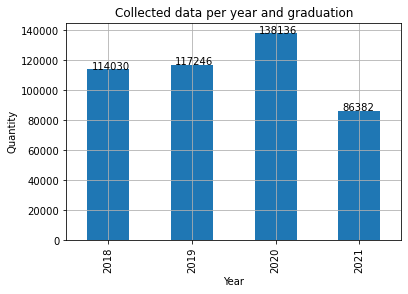

In [33]:
ax = dftmp.plot(kind="bar", legend=False)
plt.title("Collected data per year and graduation")
plt.grid('True')
plt.xlabel('Year')
plt.ylabel('Quantity')
x_offset = -0.2
y_offset = 3
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))